In [158]:
%matplotlib notebook
%matplotlib notebook
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons
import numpy as np
# import tensorflow as tf

We will make a few simple neural networks and graph their loss functions given the same task of learning to add real numbers, 
given identical training data.

## Multilayer Layer Perceptron

In [2]:
class MLP(object):
    """A class that defines a multilayer perceptron neural network by initializing
    its weights and implementing forward propagation. Please note that training must
    be done externally by modifying the weights and biases of the MLP object using
    the updating/mutator methods.
    """
    
    def __init__(self, structure: list, activations: list=None, use_bias: bool=False):
        """Initializes the weights of the neural network.
        
        Parameters
        ----------
            structure: List describing the structure of the multilayer perceptron network in
                the following format: [num_inputs, hidden_1, ... , hidden_last, num_outputs].
            activations: List of functions or callable classes to be applied at the end of
                every layer. Must be `None` for no activations at all, or of length 
                (len(structure) - 1), which is equal to the number of layers.
            use_bias: Boolean specifying whether to use bias in the network or not.
        """
        self._W = []
        self._b = []
        self.num_layers = len(structure) - 1
        if len(activations) != self.num_layers:
            raise ValueError('Length of `activations` must be equal to the number ' + 
                             'of layers in the model.')
        self.activations = activations
        
        for i in range(self.num_layers):
            self._W.append(np.random.normal(loc=0.0, scale=1.0,
                                           size=(structure[i], structure[i + 1])))
            if use_bias:
                self._b.append(np.full(fill_value=0., shape=(structure[i + 1])))
                
    def __call__(self, inputs: np.array):
        """Forward propagation.
        
        Parameters
        ----------
            inputs: Numpy ndarray of inputs with shape (batch_size, num_inputs).
        
        Returns
        -------
            Numpy ndarray of results with shape (batch_size, num_inputs).
        """
        x = inputs
        
        for i in range(self.num_layers):
            x = np.dot(x, self._W[i])
            
            if self._b:  # the empty list is False
                x = x + self._b[i]
                
            if self.activations[i]:
                x = self.activations[i](x)
        
        return x
        
    def update_W(self, delta_W, layer: int):
        """Updates `self._W` by adding `delta_W` to it.
        
        Parameters
        ----------
        delta_W: Value to add to `self._W`.
        layer: Index of layer for weight update.
        """
        self._W[layer] += delta_W
        
    def update_b(self, delta_b, layer: int):
        """Updates `self._b` by adding `delta_b` to it.
        
        Parameters
        ----------
        delta_b: Value to add to `self._b`.
        layer: Index of layer for bias update.
        """
        self._b[layer] += delta_b

## Neural ACcumulator

In [3]:
class NAC(object):
    """A class that defines a neural accumulator, as defined in this paper:
    https://arxiv.org/abs/1808.00508
    Please note that training must be done externally by updating W_hat and
    M_hat using the update methods.
    """
    
    def __init__(self, in_units: int, out_units: int):
        """Initializes the weights of the neural accumulator.
        
        Parameters
        ----------
            in_units: Number of inputs.
            out_units: Number of output units.
        """
        self._W_hat = np.random.normal(loc=0.0, scale=1.0, size=(in_units, out_units))
        self._M_hat = np.random.normal(loc=0.0, scale=1.0, size=(in_units, out_units))
        
    def __call__(self, inputs: np.array):
        """Forward propagation.
        
        Parameters
        ----------
            inputs: Numpy ndarray of inputs with shape (batch_size, in_units)
        
        Returns
        -------
            Numpy ndarray of results with shape (batch_size, out_units).
        """
        self.W = np.multiply(NAC._tanh(self._W_hat), NAC._sigmoid(self._M_hat))
        return np.dot(inputs, self.W)
    
    def update_W_hat(self, delta_W_hat):
        """Adds `delta_W_hat` to `_W_hat`.
        Parameters
        ----------
            delta_W_hat: Value to add to `self._W_hat`.
        """
        self._W_hat += delta_W_hat
        
    def update_M_hat(self, delta_M_hat):
        """Adds `delta_M_hat` to `_M_hat`.
        Parameters
        ----------
            delta_M_hat: Value to add to `self._M_hat`.
        """
        self._M_hat += delta_M_hat
    
    @staticmethod
    def _sigmoid(x):
        """Sigmoid/logistic function.
        
        >>> nac = NAC(1, 1)
        >>> a = np.array([[-100., 0., 100.], [-1.0, 0.3, 1.0]])
        >>> nac._sigmoid(a) < np.array([[0.01, 0.6, 1.01], [0.5, 0.8, 0.5]])
        array([[ True,  True,  True],
               [ True,  True, False]])
        """
        return 1 / (1 + np.exp(-1. * x))
    
    @staticmethod
    def _tanh(x):
        """Tanh function."""
        return np.tanh(x)

# import doctest
# doctest.testmod()

Let's now build an MLP and a NAC and visualize the loss funtions using the mean squared error objective function.

In [4]:
def mse(preds, targets):
    """Mean squared error objective function.
    
    Parameters
    ----------
    preds: Predictions made by the model, with shape (batch_size, num_outputs).
    targets: Target to fit the model to, with shape (batch_size, num_outputs).
    
    Returns
    -------
    Float representing the mean squared error of the predictions given the targets.
    """
    return np.average(np.square(preds - targets))

In [5]:
# activation functions are rather simple
sigmoid = lambda x: 1 / (1 + np.exp(-1. * x))
tanh = lambda x: np.tanh(x)
relu = lambda x: (x + np.absolute(x)) / 2

mlp = MLP(structure=[2, 2, 1], activations=[relu, None])

mlp.update_W(-mlp._W[0] + np.array([[1., -1.],
                                    [1., -1.]]), 0)

mlp.update_W(-mlp._W[1] + np.array([[1.],
                                    [-1.]]), 1)
mlp._W

[array([[ 1., -1.],
        [ 1., -1.]]), array([[ 1.],
        [-1.]])]

In [6]:
mlp(np.array([[2., 3.], [5, -7.5]]))

array([[ 5. ],
       [-2.5]])

In [7]:
mlp21 = MLP(structure=[2, 1], activations=[None])

mlp21.update_W(-mlp21._W[0] + np.array([[1.],
                                        [1.]]), 0)
print(mlp21._W)
mlp21(np.array([[2., 3.],
                [5., -7.5]]))

[array([[1.],
       [1.]])]


array([[ 5. ],
       [-2.5]])

In [8]:
x = np.array([
#               [2., 3.],
              [5., -7.5],
              [5., -7.5],
#               [0., 0.],
#               [-4.1, -1.9],
#               [-1., 1.2],
#               [1., 6.]
])
y = np.array([
#               [ 5. ],
              [-2.5],
              [-2.5],
#               [0.],
#               [-6.0],
#               [0.2],
#               [7.]
])

In [9]:
# w1_range = np.arange(-4.0, 4.01, 0.01)
# w2_range = np.arange(-4.0, 4.01, 0.01)
# loss_map = np.empty(shape=(w1_range.shape[0], w2_range.shape[0]))

# for row in range(w1_range.shape[0]):
#     for col in range(w2_range.shape[0]):
#         mlp21._W[0] = np.array([[w1_range[row]],
#                                 [w2_range[col]]])
#         loss_map[row, col] = mse(mlp21(x), y)

In [10]:
# plt.imshow(loss_map)
# plt.colorbar()
# plt.show()

In [120]:
x = np.array([
              [2., 3.],
#               [5., -7.5],
#               [5., -7.5],
#               [0., 0.],
#               [-4.1, -1.9],
#               [-1., 1.2],
#               [1., 6.]
])
y = np.array([
              [ 5. ],
#               [-2.5],
#               [-2.5],
#               [0.],
#               [-6.0],
#               [0.2],
#               [7.]
])

# w1_range = np.arange(-4.0, 4.01, 0.01)
# w2_range = np.arange(-4.0, 4.01, 0.01)
# loss_map = np.empty(shape=(w1_range.shape[0], w2_range.shape[0]))

# for row in range(w1_range.shape[0]):
#     for col in range(w2_range.shape[0]):
#         mlp21._W[0] = np.array([[w1_range[row]],
#                                 [w2_range[col]]])
#         loss_map[row, col] = mse(mlp21(x), y)
        
# plt.figure(figsize=(10, 10))
# plt.imshow(np.log(loss_map))
# plt.colorbar()
# plt.show()

In [12]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.log(loss_map[400:600, 400:600]))
# plt.colorbar()
# plt.show()

In [13]:
# loss_map[240, 241] - loss_map[240, 240] / 0.01

In [14]:
# print(loss_map[500, 500])
# print((w1_range[500], w2_range[500]))

In [15]:
# mlp21._W[0] = np.array([[w1_range[500]],
#                         [w2_range[500]]])
# mlp21(x)

In [16]:
# y

In [28]:
mlp221 = MLP(structure=[2, 2, 1], activations=[relu, None])

w11_range = np.arange(-1.5, 1.55, 0.05)
w12_range = np.arange(-1.5, 1.55, 0.05)
# w13_range = np.arange(-1.5, 1.55, 0.05)
w14_range = np.arange(-1.5, 1.55, 0.05)
# w21_range = np.arange(-1.1, 1.2, 0.1)
# w22_range = np.arange(-1.1, 1.2, 0.1)
loss_map = np.empty(shape=(w11_range.shape[0],
                           w12_range.shape[0],
#                            w13_range.shape[0],
                           w14_range.shape[0]))


for i in range(w11_range.shape[0]):
    for j in range(w12_range.shape[0]):
#         for k in range(w13_range.shape[0]):
        for l in range(w14_range.shape[0]):
            # for m in range(w21_range.shape[0]):
            #     for n in range(w22_range.shape[0]):
            mlp221._W = [np.array([[w11_range[i], w12_range[j]],
                                    [1., w14_range[l]]]),
                         np.array([[1.],
                                   [-1.]])]
            loss_map[i, j, l] = mse(mlp221(x), y)


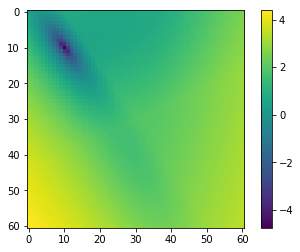

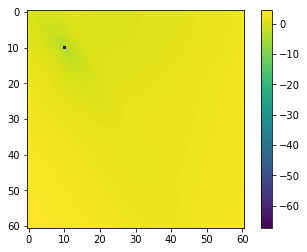

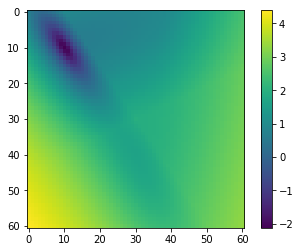

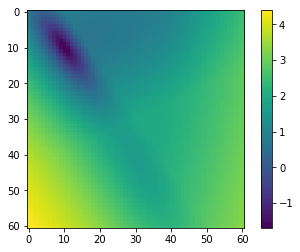

In [53]:
# # plt.subplots(221)
# plt.imshow(loss_map[0])
# plt.show()
# # plt.subplots(222)
# plt.imshow(loss_map[0])
# plt.show()
# # plt.subplots(223)

plt.imshow(np.log(loss_map[48, :, :, 0]))
plt.colorbar()
plt.show()
# plt.subplots(224)
plt.imshow(np.log(loss_map[50, :, :, 0]))
plt.colorbar()
plt.show()

plt.imshow(np.log(loss_map[58, :, :, 0]))
plt.colorbar()
plt.show()

plt.imshow(np.log(loss_map[60, :, :, 0]))
plt.colorbar()
plt.show()

In [37]:
loss_map.shape

(61, 61, 61, 61)

In [42]:
w11_range[50]

1.0000000000000022

<IPython.core.display.Javascript object>


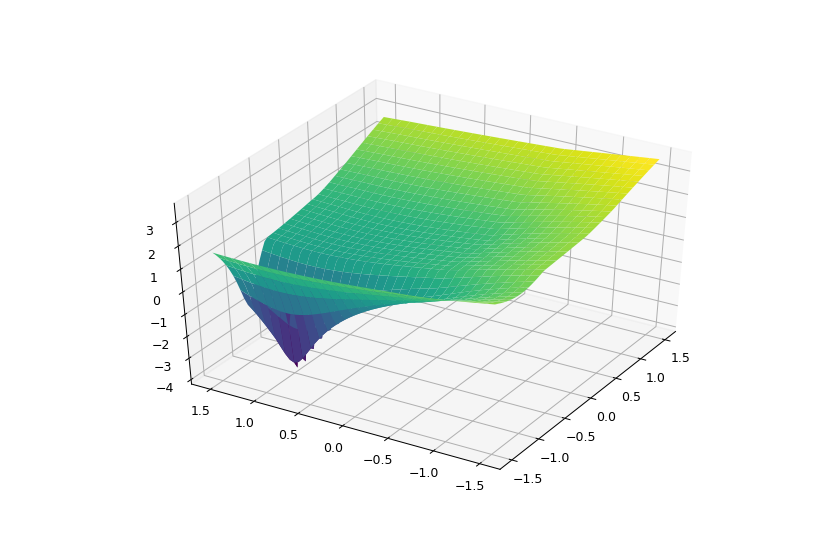

In [94]:
X, Y = np.meshgrid(w11_range, w12_range)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.log(loss_map[:, 11, :, 0]), cmap='viridis')

<IPython.core.display.Javascript object>


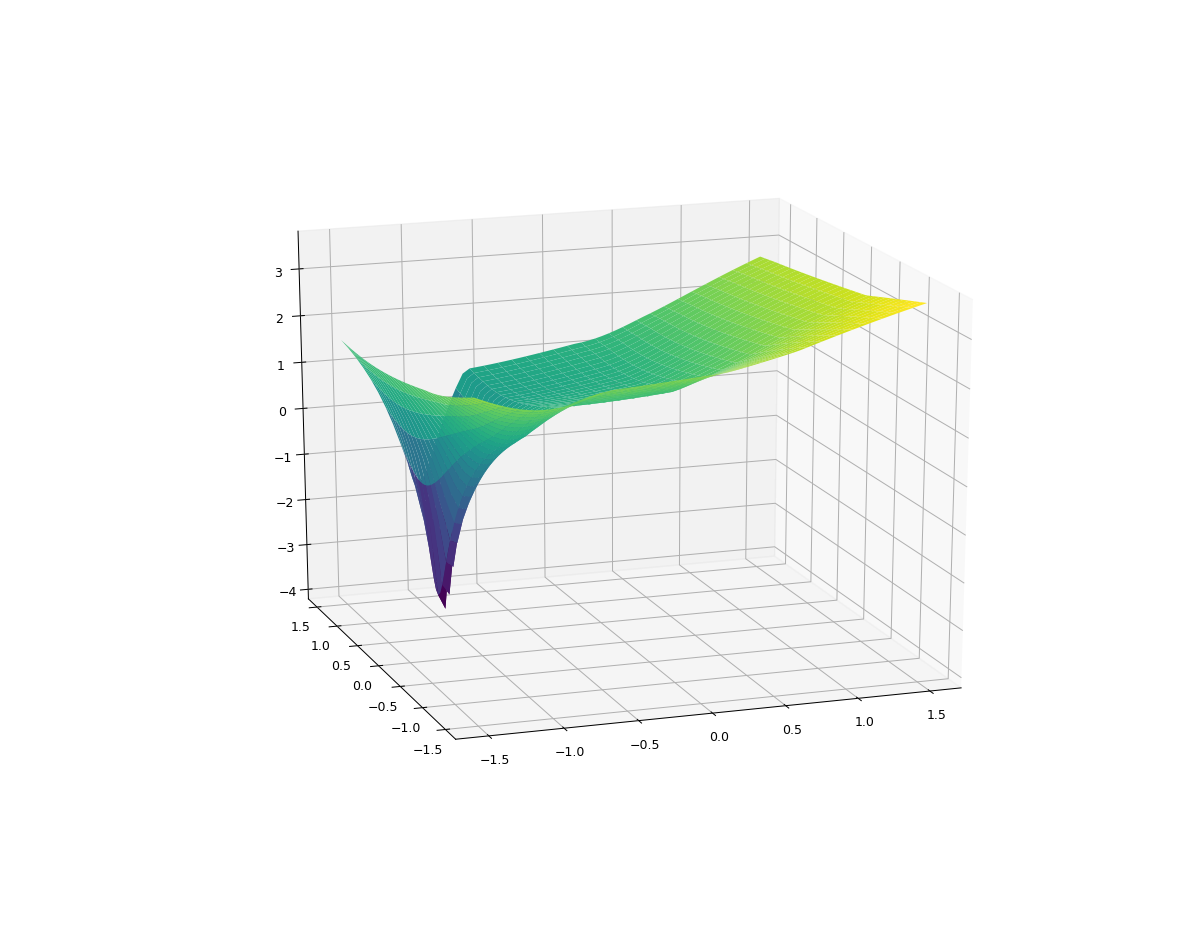

In [95]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.log(loss_map[:, 11, :, 0]), cmap='viridis')

In [126]:
nac = NAC(in_units=2, out_units=1)

w11_range = np.arange(-3.0, 3.1, 0.1)
w12_range = np.arange(-3.0, 3.1, 0.1)
w13_range = np.arange(-3.0, 3.1, 0.1)
w14_range = np.arange(-3.0, 3.1, 0.1)
# w21_range = np.arange(-1.1, 1.2, 0.1)
# w22_range = np.arange(-1.1, 1.2, 0.1)
loss_map = np.empty(shape=(w11_range.shape[0],
                           w12_range.shape[0],
                           w13_range.shape[0],
                           w14_range.shape[0]))


for i in range(w11_range.shape[0]):
    for j in range(w12_range.shape[0]):
        for k in range(w13_range.shape[0]):
            for l in range(w14_range.shape[0]):
                # for m in range(w21_range.shape[0]):
                #     for n in range(w22_range.shape[0]):
                nac._W_hat = np.array([[w11_range[i]],
                                       [w12_range[j]]])
                nac._M_hat = np.array([[w13_range[k]],
                                       [w14_range[l]]])
                loss_map[i, j, k, l] = mse(nac(x), y)

<IPython.core.display.Javascript object>


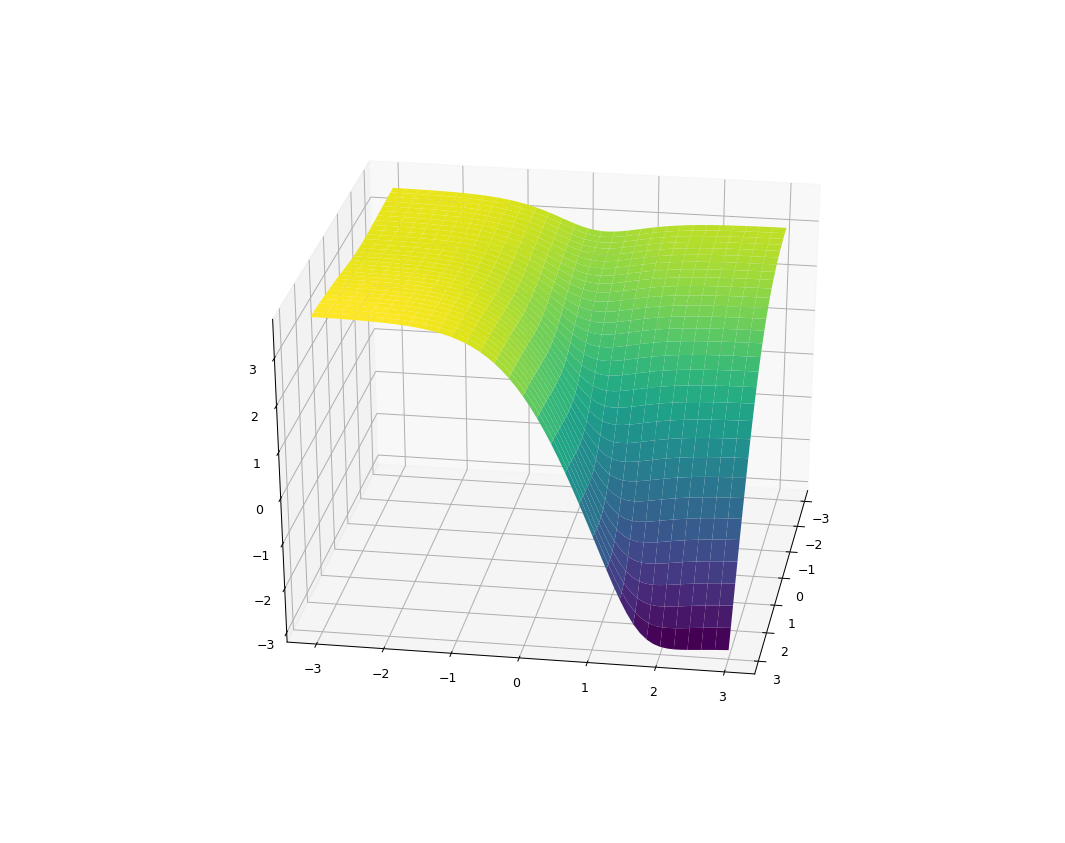

In [119]:
X, Y = np.meshgrid(w11_range, w12_range)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.log(loss_map[:, 60, :]), cmap='viridis')

<IPython.core.display.Javascript object>


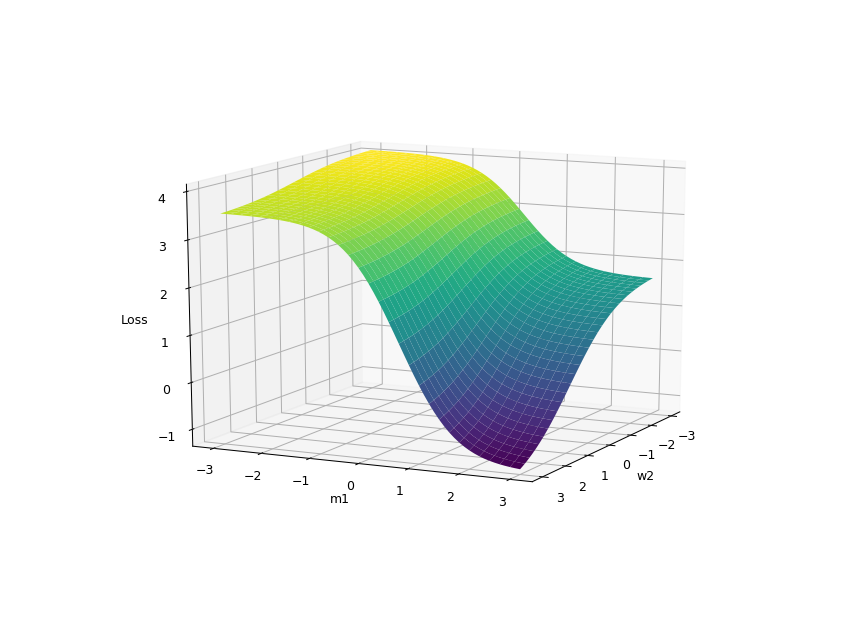

Text(0.5,0,'Loss')

In [154]:
X, Y = np.meshgrid(w11_range, w12_range)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.log(loss_map[50, :, :, 50]), cmap='viridis')
ax.set_xlabel('w2')
ax.set_ylabel('m1')
ax.set_zlabel('Loss')

In [148]:
x, y

(array([[2., 3.]]), array([[5.]]))

<IPython.core.display.Javascript object>


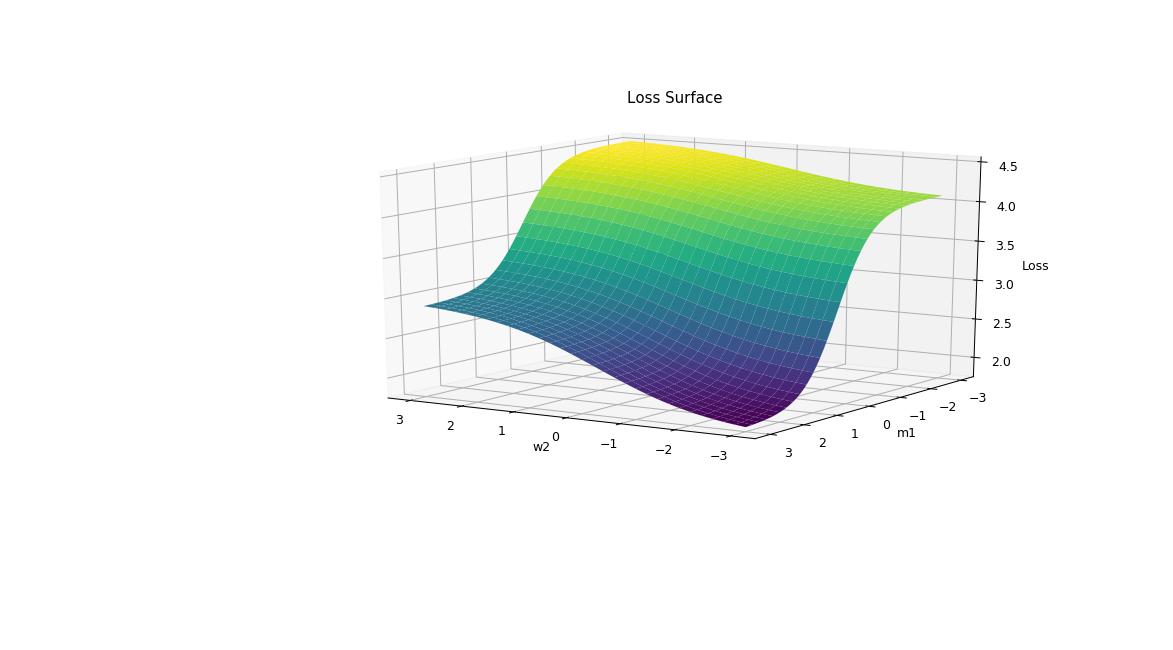

Text(0.5,0.92,'Loss Surface')

In [185]:
X, Y = np.meshgrid(w11_range, w12_range)

fig = plt.figure()
plt.subplots_adjust(left=0.25, bottom=0.25)
ax = plt.axes(projection='3d')
plot = ax.plot_surface(X, Y, np.log(loss_map[5, :, :, 50]), cmap='viridis')
ax.set_xlabel('w2')
ax.set_ylabel('m1')
ax.set_zlabel('Loss')
ax.set_title('Loss Surface')

# axcolor = 'lightgreen'
# axw2 = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
# axm1 = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

# sw1 = Slider(axw2, 'W2', 0, 60, valinit=50, valstep=1)
# sm2 = Slider(axm1, 'M1', 0, 60, valinit=50, valstep=1)

# def do_update(val):
#     w1 = sw1.val
#     m2 = sm2.val
#     ax.clear()
#     plot = ax.plot_surface(X, Y, np.log(loss_map[w1, :, :, m2]), cmap='viridis')
#     ax.set_xlabel('w2')
#     ax.set_ylabel('m1')
#     ax.set_zlabel('Loss')
#     ax.set_title('Loss Surface')
#     fig.canvas.draw()
# sw1.on_changed(do_update)
# sm2.on_changed(do_update)